In [1]:
import numpy as np
from pycbf.gpu import TabbedBeamformer, TabbedDMASBeamformer
# from pycbf.cpu import TabbedBeamformer
import matplotlib.pyplot as plt
import timuscle.beamforming as tibf
import pycbf.dataio as dio
from scipy.signal import hilbert, filtfilt, butter

from tqdm.notebook import tqdm

from time import time

In [2]:
data = dio.loadHDF5asdict("channel_data_exvivo_bovine.h5")

rf = data['rf']
dims = data['dims']
c0 = data['c0']
f0 = data['f0']

t = dims['t_sec']
xele = dims['xele_m']
steers = np.radians(dims['steer_deg'])

lam = c0/f0

In [3]:
sospeak = 1540

fnum = 1

dsfx = 2
dsfz = 2*dsfx

xout, zout = tibf.make_recon_grid_by_BW_2D(
    fnum = fnum,
    lam = lam,
    xmin = -20E-3,
    xmax = 20E-3,
    zmin = 1E-3,
    zmax = 55E-3,
    BWx = 0.67,
    BWz = 4
)

# dz = (zout[-1]-zout[0])/len(zout)


# chunk = len(xout)//8
# xout = xout[chunk:-chunk]

dz = zout[1]-zout[0]
nkern = int(np.ceil(0.5 * lam / (dz)/2))

tautx, taurx, apodtx, apodrx = tibf.make_tabs_and_apods_2D(
    steers=steers,
    r0 = 0,
    ctx=c0,
    cm=sospeak,
    xele=xele,
    xout=xout,
    zout=zout,
    fnum=fnum
)

In [ ]:
nlag = 10
subset = rf[1]

t1 = time()
bmfrm = TabbedBeamformer(
    tautx=tautx,
    taurx=taurx,
    apodtx=apodtx,
    apodrx=apodrx,
    t0 = t[0],
    dt = t[1]-t[0],
    nt = len(t),
    # interp=dict(kind='korder_cubic', k=16),
    sumtype='tx_only'
)
t2 = time()
im_txsum = bmfrm(subset).reshape(taurx.shape[0], len(xout), len(zout))
# np.nan_to_num(im, copy=False, posinf=0, neginf=0)
t3 = time()

del bmfrm

print(f"make beamformer: {1000*(t2-t1):0.02f} ms, beamform: {1000*(t3-t2):0.02f} ms")

In [ ]:
np.sum(im_txsum, axis=0)

array([[ 206124.9  ,  224478.6  ,  139093.9  , ..., -368003.44 ,
        -597673.3  , -581773.25 ],
       [  90443.   ,  318910.06 ,  386857.44 , ...,  318150.38 ,
          67782.45 , -123711.44 ],
       [  72210.98 ,  482223.28 ,  651327.25 , ...,  -39252.125,
         -79461.38 ,  -90625.766],
       ...,
       [ -66193.31 ,  232463.36 ,  349115.75 , ...,   66779.766,
         250536.94 ,  316160.06 ],
       [ -98316.55 ,  152734.36 ,  271673.16 , ...,  183531.56 ,
          38050.695, -120817.71 ],
       [ -94569.36 ,   68921.984,  165274.7  , ..., -157798.   ,
         -21886.049,  183150.52 ]], shape=(181, 2918), dtype=float32)

In [ ]:
from pycbf.gpu.__engines__ import calc_dmas
import cupy as cp

In [ ]:
nblock = int(np.ceil(10 * np.prod(im_txsum.shape) / 512))

imout_cp = cp.zeros((im_txsum.shape[1],im_txsum.shape[2]), dtype=cp.float32)

dmas_params = (
    cp.array(im_txsum),
    np.int32(im_txsum.shape[0]),
    np.int32(im_txsum.shape[1]*im_txsum.shape[2]),
    cp.arange(1, 10+1, dtype=cp.int32),
    np.int32(10),
    np.int32(0), # (0) -> SSR, (1) -> power
    np.int32(1), # sum all lags
    imout_cp
)

calc_dmas((nblock, 1, 1), (512, 1, 1), dmas_params)

imout_ssr = cp.asnumpy(imout_cp)

imout_cp = cp.zeros((im_txsum.shape[1],im_txsum.shape[2]), dtype=cp.float32)

dmas_params = (
    cp.array(im_txsum),
    np.int32(im_txsum.shape[0]),
    np.int32(im_txsum.shape[1]*im_txsum.shape[2]),
    cp.arange(1, 10+1, dtype=cp.int32),
    np.int32(10),
    np.int32(1), # (0) -> SSR, (1) -> power
    np.int32(1), # sum all lags
    imout_cp
)

calc_dmas((nblock, 1, 1), (512, 1, 1), dmas_params)

imout_p = cp.asnumpy(imout_cp)

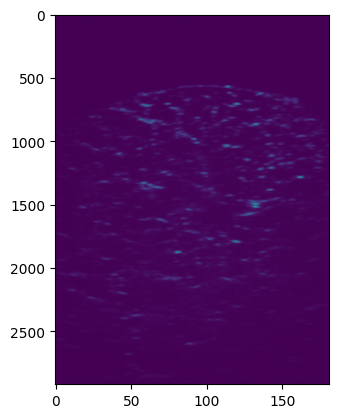

In [ ]:
plt.figure()
plt.imshow(imout_ssr.T, aspect=0.67/8)
plt.show()

plt.figure()
plt.imshow(imout_p.T, aspect=0.67/8)
plt.show()

In [5]:
nlag = 10
subset = rf[1]

t1 = time()
bmfrm = TabbedDMASBeamformer(
    tautx=tautx,
    taurx=taurx,
    apodtx=apodtx,
    apodrx=apodrx,
    t0 = t[0],
    dt = t[1]-t[0],
    nt = len(t),
    lags = np.arange(1, 10+1, dtype=int),
    dmastype="power"
)
t2 = time()
im_dmas = bmfrm(subset).reshape(len(xout), len(zout))
# np.nan_to_num(im, copy=False, posinf=0, neginf=0)
t3 = time()

del bmfrm

print(f"make beamformer: {1000*(t2-t1):0.02f} ms, beamform: {1000*(t3-t2):0.02f} ms")

[nan nan nan ... nan nan nan]
make beamformer: 282.48 ms, beamform: 124.15 ms


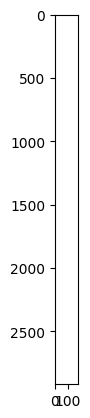

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(181, 2918), dtype=float32)

In [6]:
plt.figure()
plt.imshow(im_dmas.T)
plt.show()

im_dmas